In [1]:
### Xi -> reference representation  Xj -> target representation
## adjust reference Xi  to  Xi' => CKA(Xi', Xj) ----> 1
# R -> min ||XjR - Xi'||

##### adjust : keep similar samples and highlight the diff samples' difference 
# step1: find diff samples and same samples
# step2: adjust diff samples or just keep the same set

In [2]:
#####
### adjust : use target_diff_Set , ref_diff_set cauculate S_for_diff,R_for_diff CKA(ref_diff_set * S_for_diff, target_diff_set) -> 1
####    CKA(ref_diff_set, target_diff_set * R_for_diff) -> 1
#### CKA(ref_same_set, tar_same_set) -> 1  => CKA(ref_same_set+ref_diff_set * S_for_diff, tar_diff_Set + tar_same_set) -> 1
##### adjusted_Ref = ref_same_set+ref_diff_set * S_for_diff

In [1]:
#### 

import torch
import sys
sys.path.append("..")
from singleVis.data import NormalDataProvider
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"

CLEAN_PATH = "/home/yifan/dataset/clean_ref/pairflip/cifar10/0"
sys.path.append(REF_PATH)


from config import config

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
PREPROCESS = VISUALIZATION_PARAMETER["PREPROCESS"]
LAMBDA = VISUALIZATION_PARAMETER["LAMBDA"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
INIT_NUM = VISUALIZATION_PARAMETER["INIT_NUM"]
ALPHA = VISUALIZATION_PARAMETER["ALPHA"]
BETA = VISUALIZATION_PARAMETER["BETA"]
MAX_HAUSDORFF = VISUALIZATION_PARAMETER["MAX_HAUSDORFF"]
# HIDDEN_LAYER = VISUALIZATION_PARAMETER["HIDDEN_LAYER"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
T_N_EPOCHS = VISUALIZATION_PARAMETER["T_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = 'vis'
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

SEGMENTS = [(EPOCH_START, EPOCH_END)]
# define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))


ref_provider = NormalDataProvider(REF_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)
tar_provider = NormalDataProvider(CLEAN_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)
ref_train_data = ref_provider.train_representation(200).squeeze()
tar_train_data = tar_provider.train_representation(200).squeeze()
ref_prediction = ref_provider.get_pred(200, ref_train_data)
tar_prediction = tar_provider.get_pred(200, tar_train_data)
ref_prediction_res = ref_prediction.argmax(axis=1)
tar_prediction_res = tar_prediction.argmax(axis=1)
### get confidence scores result
from scipy.special import softmax
import numpy as np
def get_conf(pred):
    scores = np.amax(softmax(pred, axis=1), axis=1)
    return scores
ref_scores = get_conf(ref_prediction)
tar_scores =  get_conf(tar_prediction)

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Finish initialization...
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 5477.39it/s]


In [42]:
ref_labels = ref_provider.train_labels(200)

array([6, 9, 9, ..., 9, 1, 1])

In [2]:
import math
distance_high_indicates = []
same_set_indicates = []
def EMAE(Y, y, a=1.5):
    """
    param：
        Y: 原始序列（假定波动较大）
        y: 拟合序列（假定波动较小）
        a: 指数的自变量，≥1，该值越大，则两序列间的残差（特别是残差的离群值）对EMAE返回值影响的强化作用越明显；
        当a=1时，EMAE化简为MAE。
    return：
        指数MAE值，该值的大小与两条序列间平均偏差程度成正比，该值越大，平均偏差程度越大；
        且两序列间的残差（特别是残差的离群值）对EMAE的影响比MAE大。
    """

    Y, y = np.array(Y), np.array(y)
    Y[Y < 0] = 0  # 使指数的底数≥1，则所有指数均为递增函数
    y[y < 0] = 0
    emae = sum(abs((Y+1)**a - (y+1)**a)) / len(Y)

    return emae

for i in range(len(ref_prediction)):
    mes_val = EMAE(ref_prediction[i], tar_prediction[i])
    if mes_val > 25:
        distance_high_indicates.append(i)
    elif mes_val < 0.6:
        same_set_indicates.append(i)
#### 
diff_indicates = []
same_indicates = []
for i in range(len(ref_prediction)):
    # if tar_prediction_res[i] == ref_prediction_res[i] and ref_scores[i] == tar_scores[i] and  (i in same_set_indicates): 
    if tar_prediction_res[i] == ref_prediction_res[i] and math.fabs(ref_scores[i] - tar_scores[i]) < 0.1 and  (i in same_set_indicates):     
        same_indicates.append(i)
    else:
        diff_indicates.append(i)

# need_adjust_indicates = []
# for i in range(len(ref_prediction)):
#     if tar_prediction_res[i] == ref_prediction_res[i] and ref_scores[i] == tar_scores[i] and  (i in same_set_indicates):     
#         same_indicates.append(i)
#     else:
#         diff_indicates.append(i)
pred_diff_list = []
for i in range(len(ref_prediction)):
    # if tar_prediction_res[i] == ref_prediction_res[i] and ref_scores[i] == tar_scores[i] and  (i in same_set_indicates): 
    if tar_prediction_res[i] != ref_prediction_res[i] or math.fabs(ref_scores[i] - tar_scores[i]) > 0.1:     
        pred_diff_list.append(i)

print('predict diff sample number:',len(pred_diff_list),'absolute align sample number:',len(same_indicates))

predict diff sample number: 89 absolute align sample number: 88


In [5]:

# Step2: Computing the loss 
def compute_loss(X, Y, R):
    '''
    Inputs: 
       X: a matrix of dimension (m,n) where the columns are the English embeddings.
       Y: a matrix of dimension (m,n) where the columns correspong to the French embeddings.
       R: a matrix of dimension (n,n) - transformation matrix from English to French vector space embeddings.
    Outputs:
       L: a matrix of dimension (m,n) - the value of the loss function for given X, Y and R.
    '''
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # m is the number of rows in X
    m = len(X)

    # diff is XR - Y
    diff = np.dot(X, R) - Y

    # diff_squared is the element-wise square of the difference
    diff_squared = diff**2

    # sum_diff_squared is the sum of the squared elements
    sum_diff_squared = diff_squared.sum()

    # loss is the sum_diff_squared divided by the number of examples (m)
    loss = sum_diff_squared/m
    ### END CODE HERE ###
    return loss
def compute_gradient(X, Y, R):
    '''
        the gradient of the loss with respect to the matrix encodes how much a tiny change 
    in some coordinate of that matrix affect the change of loss function.
        Gradient descent uses that information to iteratively change matrix R until we reach 
    a point where the loss is minimized.
    Inputs: 
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        R: a matrix of dimension (n,n) - transformation matrix from Y2d to X2d
    Outputs:
       g: a matrix of dimension (n,n) - gradient of the loss function L for given X, Y and R.
    '''
    # m is the number of rows in X
    m = len(X)

    rows, columns = X.shape

    gradient = (np.dot(X.T, np.dot(X, R) - Y) * 2)/rows
    assert gradient.shape == (columns, columns)
    ### END CODE HERE ###
    return gradient


# Most of the time we iterate for a fixed number of training steps rather than iterating until the loss falls below a threshold.

# 1.Calculate gradient g of the loss with respect to the matrix R. 
# 2. Update R (Rnew = Rold - αg) . α is the learning rate which is a scalar.

# alignment_embeddings
def align_embeddings(X: np.ndarray, Y: np.ndarray,
                      train_steps:int,
                      learning_rate: float=0.0003,
                      seed: int=129) -> np.ndarray:
    '''
    Finding the optimal R with gradient descent algorithm
    Inputs:
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        learning_rate: positive float - describes how big steps will  gradient descent algorithm do.
    Outputs:
        R: a matrix of dimension (n,n) - the projection matrix that minimizes the F norm ||projector(X R) - projector ( Y )||^2
    '''
    # the number of columns in X is the number of dimensions for a word vector (e.g. 300)
    # R is a square matrix with length equal to the number of dimensions in th  word embedding
    R = np.random.rand(X.shape[1], X.shape[1])
    # R = Variable(torch.ones(X.shape[1],X.shape[1]),requires_grad=True)

   

        
    # train_steps = 100000
    for i in range(train_steps):
        if i%500 == 0:
            loss = compute_loss(X,Y,R)
            print(f"iteration {i}, loss {loss}") 



        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
        # use the function that you defined to compute the gradient
        gradient = compute_gradient(X, Y, R)
       
        
         # update R by subtracting the learning rate times gradient
        R -= learning_rate * gradient
        ### END CODE HERE ###
    
    return R


In [34]:
import os
import sys
sys.path.append("..")
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
X = ref_train_data[same_indicates]
Y = tar_train_data[same_indicates]

# print('Linear CKA, between X and Y: {}'.format(np_cka.linear_CKA(X, Y)))
print('RBF Kernel CKA, between X and Y: {}'.format(np_cka.kernel_CKA(X, Y)))

RBF Kernel CKA, between X and Y: 0.9637494155627727


In [36]:
# use prediction differenct subset train S_for_diff, use S_for_diff generate diff predict samples
X = ref_train_data[pred_diff_list]
Y = tar_train_data[pred_diff_list]
S_for_diff = align_embeddings(X, Y, 25000)

iteration 0, loss 14727726.015006997
iteration 500, loss 1652.9341780576788
iteration 1000, loss 942.669793479484
iteration 1500, loss 616.2566979840126
iteration 2000, loss 429.7384590183959
iteration 2500, loss 312.275965457699
iteration 3000, loss 233.650705473302
iteration 3500, loss 178.7251605092336
iteration 4000, loss 139.10600465226156
iteration 4500, loss 109.80093232154384
iteration 5000, loss 87.68138837965104
iteration 5500, loss 70.70467618003521
iteration 6000, loss 57.49180111540129
iteration 6500, loss 47.085602363769475
iteration 7000, loss 38.80593354685626
iteration 7500, loss 32.1596884994208
iteration 8000, loss 26.78310907958266
iteration 8500, loss 22.403768043159523
iteration 9000, loss 18.814911840166648
iteration 9500, loss 15.857776937957011
iteration 10000, loss 13.409172245254199
iteration 10500, loss 11.37261306567955
iteration 11000, loss 9.671895575397452
iteration 11500, loss 8.246376926008471
iteration 12000, loss 7.047465723749168
iteration 12500, lo

In [37]:
#### 
import os
import sys
sys.path.append("..")
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
X = np.dot(ref_train_data[pred_diff_list],S_for_diff)
Y = tar_train_data[pred_diff_list]

# print('Linear CKA, between X and Y: {}'.format(np_cka.linear_CKA(X, Y)))
print('RBF Kernel CKA, between np.dot(ref_train_data[pred_diff_list],S_for_diff) and tar_train_data[pred_diff_list]: {}'.format(np_cka.kernel_CKA(X, Y)))

RBF Kernel CKA, between np.dot(ref_train_data[pred_diff_list],S_for_diff) and tar_train_data[pred_diff_list]: 0.9999178560614356


In [38]:
#### the CKA is lower than expect
test_X = np.concatenate((ref_train_data[same_indicates], np.dot(ref_train_data[pred_diff_list],S_for_diff)),axis=0)
test_Y = np.concatenate((tar_train_data[same_indicates], tar_train_data[pred_diff_list]),axis=0)
import os
import sys
sys.path.append("..")
from CKA_utils.CKA import CKA, CudaCKA

np_cka = CKA()
X = torch.Tensor(test_X)
Y = torch.Tensor(test_Y)

# print('Linear CKA, between X and Y: {}'.format(np_cka.linear_CKA(X, Y)))
print('RBF Kernel CKA, between X and Y: {}'.format(np_cka.kernel_CKA(X, Y)))

RBF Kernel CKA, between X and Y: 0.843712587313168


In [39]:
### train metrix make the CKA higher
pro_back_to_ref_metrix = align_embeddings(np.dot(ref_train_data[pred_diff_list],S_for_diff), ref_train_data[pred_diff_list], 25000)

iteration 0, loss 14371406.476109121
iteration 500, loss 1709.9857246803795
iteration 1000, loss 975.4577008872652
iteration 1500, loss 639.4230856645097
iteration 2000, loss 445.94931870362643
iteration 2500, loss 323.8168633822642
iteration 3000, loss 242.12887018958253
iteration 3500, loss 185.15754670967104
iteration 4000, loss 144.12890687976835
iteration 4500, loss 113.82014893879737
iteration 5000, loss 90.962870823355
iteration 5500, loss 73.42779915934125
iteration 6000, loss 59.78102171942909
iteration 6500, loss 49.02968277532059
iteration 7000, loss 40.469885934296485
iteration 7500, loss 33.59236425416838
iteration 8000, loss 28.022120326112365
iteration 8500, loss 23.4787390870233
iteration 9000, loss 19.74966425034745
iteration 9500, loss 16.671821869445655
iteration 10000, loss 14.11874598487452
iteration 10500, loss 11.991407523143524
iteration 11000, loss 10.211582721193176
iteration 11500, loss 8.716992556000301
iteration 12000, loss 7.457696142979411
iteration 12500

In [41]:
test_X = np.concatenate((ref_train_data[same_indicates], np.dot(np.dot(ref_train_data[pred_diff_list],S_for_diff),pro_back_to_ref_metrix)),axis=0)
test_Y = np.concatenate((tar_train_data[same_indicates], tar_train_data[pred_diff_list]),axis=0)
import os
import sys
sys.path.append("..")
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
X = test_X
Y = test_Y

# print('Linear CKA, between X and Y: {}'.format(np_cka.linear_CKA(X, Y)))
print('RBF Kernel CKA, between X and Y: {}'.format(np_cka.kernel_CKA(X, Y)))

RBF Kernel CKA, between X and Y: 0.9110821558720215


In [23]:
new_diff_representations = np.dot(np.dot(ref_train_data[pred_diff_list],S_for_diff),pro_back_to_ref_metrix)

In [26]:
ref_train_data[pred_diff_list].shape

(89, 512)

In [19]:

import os
import sys
sys.path.append("..")
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
X = np.dot(ref_train_data[pred_diff_list],S_for_diff)
Y = tar_train_data[pred_diff_list]

# print('Linear CKA, between X and Y: {}'.format(np_cka.linear_CKA(X, Y)))
print('RBF Kernel CKA, between X and Y: {}'.format(np_cka.kernel_CKA(X, Y)))

RBF Kernel CKA, between X and Y: 0.9986608176602467


In [20]:
test_X = np.concatenate((ref_train_data[same_indicates], ref_train_data[pred_diff_list]),axis=0)
test_Y = np.concatenate((tar_train_data[same_indicates], tar_train_data[pred_diff_list]),axis=0)
import os
import sys
sys.path.append("..")
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
X = test_X
Y = test_Y

# print('Linear CKA, between X and Y: {}'.format(np_cka.linear_CKA(X, Y)))
print('RBF Kernel CKA, between X and Y: {}'.format(np_cka.kernel_CKA(X, Y)))

RBF Kernel CKA, between X and Y: 0.9103170375141223


In [21]:
import os
import sys
sys.path.append("..")
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
X = ref_train_data[pred_diff_list]
Y = tar_train_data[pred_diff_list]

# print('Linear CKA, between X and Y: {}'.format(np_cka.linear_CKA(X, Y)))
print('RBF Kernel CKA, between X and Y: {}'.format(np_cka.kernel_CKA(X, Y)))

RBF Kernel CKA, between X and Y: 0.830499269046473


In [22]:
# use absolute subset train R, use R generate diff predict samples
X = ref_train_data[same_indicates]
Y = tar_train_data[same_indicates]

# X_pred = exchange_provider.get_pred(200, ref_provider.train_representation(200))
# Y_pred = ref_provider.get_pred(200, ref_provider.train_representation(200))
R = align_embeddings(Y, X, 25000)

iteration 0, loss 29985669.6670063
iteration 500, loss 1647.6384727934112
iteration 1000, loss 887.0948533015916
iteration 1500, loss 549.2885103063277
iteration 2000, loss 367.2979506754851
iteration 2500, loss 257.85871078244
iteration 3000, loss 187.2394665794559
iteration 3500, loss 139.39230757792149
iteration 4000, loss 105.79395191561812
iteration 4500, loss 81.54455822681903
iteration 5000, loss 63.656416028621635
iteration 5500, loss 50.223349797209046
iteration 6000, loss 39.98471312499436
iteration 6500, loss 32.081981015768626
iteration 7000, loss 25.91600810081748
iteration 7500, loss 21.059890845151212
iteration 8000, loss 17.20396450394918
iteration 8500, loss 14.120084286479266
iteration 9000, loss 11.637854289311234
iteration 9500, loss 9.628465048054922
iteration 10000, loss 7.993494170492412
iteration 10500, loss 6.657013844865799
iteration 11000, loss 5.559943877255989
iteration 11500, loss 4.655955792924316
iteration 12000, loss 3.9084649872305377
iteration 12500, 

KeyboardInterrupt: 

In [ ]:
# use absolute subset train R, use R generate diff predict samples
X = ref_train_data[same_indicates]
Y = tar_train_data[same_indicates]

# X_pred = exchange_provider.get_pred(200, ref_provider.train_representation(200))
# Y_pred = ref_provider.get_pred(200, ref_provider.train_representation(200))
S = align_embeddings(X, Y, 25000)

iteration 0, loss 29285439.164585903
iteration 500, loss 1648.9505399579384
iteration 1000, loss 898.5629606546883
iteration 1500, loss 556.6429305064731
iteration 2000, loss 370.8425369774781
iteration 2500, loss 258.89814192807745
iteration 3000, loss 186.8523359000371
iteration 3500, loss 138.2881530978327
iteration 4000, loss 104.3932155836143
iteration 4500, loss 80.08009789541984
iteration 5000, loss 62.24896330581737
iteration 5500, loss 48.929557075262274
iteration 6000, loss 38.82580594952536
iteration 6500, loss 31.060302220336823
iteration 7000, loss 25.024389621047415
iteration 7500, loss 20.28687720837164
iteration 8000, loss 16.53666427365855
iteration 8500, loss 13.545674509220863
iteration 9000, loss 11.14432564352694
iteration 9500, loss 9.204944059571018
iteration 10000, loss 7.630334853661695
iteration 10500, loss 6.345768488415581
iteration 11000, loss 5.293275128351332
iteration 11500, loss 4.427524753427243
iteration 12000, loss 3.712814208237567
iteration 12500, 

In [ ]:
import os
import sys
sys.path.append("..")
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
X = S
Y = R

# print('Linear CKA, between X and Y: {}'.format(np_cka.linear_CKA(X, Y)))
print('ref * S vs ref: {}'.format(np_cka.kernel_CKA(X, Y)))

ref * S vs ref: 0.5653326555437191


In [ ]:
import os
import sys
sys.path.append("..")
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
X = ref_train_data[same_indicates]
Y = ref_train_data[same_indicates]

# print('Linear CKA, between X and Y: {}'.format(np_cka.linear_CKA(X, Y)))
print('ref * S vs ref: {}'.format(np_cka.kernel_CKA(X, Y)))

ref * S vs ref: 1.0


In [ ]:
import os
import sys
sys.path.append("..")
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
X = np.dot(ref_train_data[same_indicates],S)
Y = tar_train_data[same_indicates]

# print('Linear CKA, between X and Y: {}'.format(np_cka.linear_CKA(X, Y)))
print('ref * S vs tar: {}'.format(np_cka.kernel_CKA(X, Y)))

ref * S vs tar: 0.9999998794499331


In [ ]:
ref_all.shape

(177, 512)

In [ ]:
# use absolute subset train R, use R generate diff predict samples
X = ref_train_data[pred_diff_list]
Y = tar_train_data[pred_diff_list]

# X_pred = exchange_provider.get_pred(200, ref_provider.train_representation(200))
# Y_pred = ref_provider.get_pred(200, ref_provider.train_representation(200))
R_for_diff = align_embeddings(Y, X, 35000)

In [ ]:
# use absolute subset train R, use R generate diff predict samples
X = ref_train_data[pred_diff_list]
Y = tar_train_data[pred_diff_list]

# X_pred = exchange_provider.get_pred(200, ref_provider.train_representation(200))
# Y_pred = ref_provider.get_pred(200, ref_provider.train_representation(200))
S_for_diff = align_embeddings(X, Y, 15000)

iteration 0, loss 14721150.27970193
iteration 500, loss 1647.2973998631214
iteration 1000, loss 942.2040606410438
iteration 1500, loss 617.4589504247168
iteration 2000, loss 431.4161887257388
iteration 2500, loss 313.9853092117712
iteration 3000, loss 235.23613051293378
iteration 3500, loss 180.1429118015782
iteration 4000, loss 140.35435219791955
iteration 4500, loss 110.8926153182435
iteration 5000, loss 88.63295590317638
iteration 5500, loss 71.5325830849845
iteration 6000, loss 58.21115079351813
iteration 6500, loss 47.709878121758365
iteration 7000, loss 39.347064167674546
iteration 7500, loss 32.6282022244227
iteration 8000, loss 27.188292467193374
iteration 8500, loss 22.753807206298813
iteration 9000, loss 19.11701421121661
iteration 9500, loss 16.118277105562075
iteration 10000, loss 13.633625661492271
iteration 10500, loss 11.565880372685896
iteration 11000, loss 9.83821924480344
iteration 11500, loss 8.389451168260528
iteration 12000, loss 7.170500201518934
iteration 12500, 

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 6009.07it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

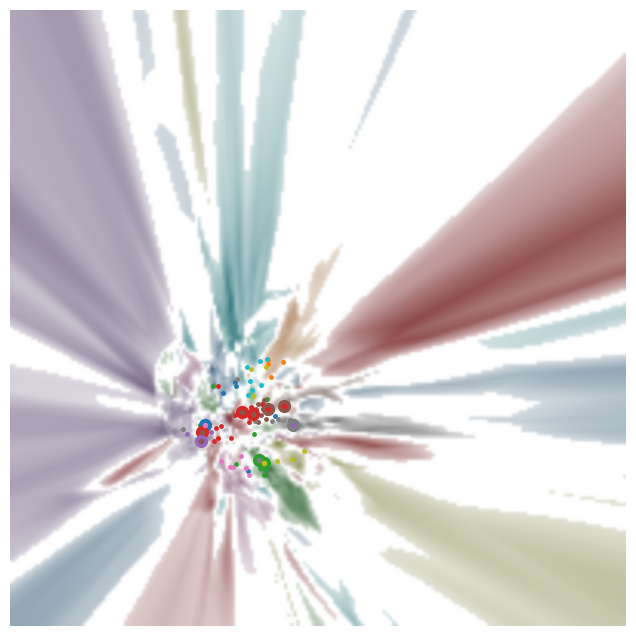

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, S_for_diff,I, np.dot(tar_provider.train_representation(200),R_for_diff), projector, 200,[pred_diff_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
import os
import sys
sys.path.append("..")
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
X = np.dot(ref_train_data[pred_diff_list],S_for_diff)
Y = tar_train_data[pred_diff_list]

# print('Linear CKA, between X and Y: {}'.format(np_cka.linear_CKA(X, Y)))
print('ref * S vs tar: {}'.format(np_cka.kernel_CKA(X, Y)))

ref * S vs tar: 0.999992607892217


In [ ]:
import copy
adjust_ref = copy.deepcopy(ref_train_data)

for i in range(len(pred_diff_list)):
    index = pred_diff_list[i]
    
    adjust_ref[index] = np.dot(adjust_ref[index],S_for_diff )
    

In [ ]:
#### same_set representation CKA
import numpy as np
from sklearn.cross_decomposition import CCA
# 建立模型
X = adjust_ref[pred_diff_list]
Y = tar_train_data[pred_diff_list]
cca = CCA(n_components=1)
# 训练数据
cca.fit(X, Y)
# print(X)
X_train_r, Y_train_r = cca.transform(X, Y)
# print(X_train_r)
print('referece epoch 200 vs target epoch 200')
print(np.corrcoef(X_train_r[:, 0], Y_train_r[:, 0])[0, 1]) #输出相关系数

referece epoch 200 vs target epoch 200
1.0


In [ ]:
#### same_set representation CKA
import numpy as np
from sklearn.cross_decomposition import CCA
# 建立模型
X = ref_train_data[pred_diff_list]
Y = tar_train_data[pred_diff_list]
cca = CCA(n_components=1)
# 训练数据
cca.fit(X, Y)
# print(X)
X_train_r, Y_train_r = cca.transform(X, Y)
# print(X_train_r)
print('referece epoch 200 vs target epoch 200')
print(np.corrcoef(X_train_r[:, 0], Y_train_r[:, 0])[0, 1]) #输出相关系数

referece epoch 200 vs target epoch 200
0.9999999999999997


In [ ]:
adjust_ref.shape

(50000, 512)

In [ ]:
import os
import sys
sys.path.append("..")
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
X = np.dot(tar_train_data[same_indicates],R)
Y = tar_train_data[same_indicates]

# print('Linear CKA, between X and Y: {}'.format(np_cka.linear_CKA(X, Y)))
print('RBF Kernel CKA, between X and Y: {}'.format(np_cka.kernel_CKA(X, Y)))

RBF Kernel CKA, between X and Y: 0.9639875178425626


In [ ]:
import os
import sys
sys.path.append("..")
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
X = np.dot(tar_train_data[same_indicates],R)
Y = tar_train_data[same_indicates]

# print('Linear CKA, between X and Y: {}'.format(np_cka.linear_CKA(X, Y)))
print('RBF Kernel CKA, between X and Y: {}'.format(np_cka.kernel_CKA(X, Y)))

RBF Kernel CKA, between X and Y: 0.9639953267101925


In [ ]:
#### same_set representation CKA
import numpy as np
from sklearn.cross_decomposition import CCA
# 建立模型
X = ref_train_data[same_indicates]
Y = tar_train_data[same_indicates]
cca = 
(n_components=1)
# 训练数据
cca.fit(X, Y)
# print(X)
X_train_r, Y_train_r = cca.transform(X, Y)
# print(X_train_r)
print('referece epoch 200 vs target epoch 200')
print(np.corrcoef(X_train_r[:, 0], Y_train_r[:, 0])[0, 1]) #输出相关系数

referece epoch 200 vs target epoch 200
0.9999999999999996


In [ ]:
## 
gen_diff_by_tarR = np.dot(tar_train_data[pred_diff_list],R)

In [ ]:
gen_diff_by_tarR.shape

(17, 512)

In [ ]:
need_train = same_indicates + pred_diff_list

In [ ]:
import os
import sys
sys.path.append("..")
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
X = ref_train_data[need_train]
Y = tar_train_data[need_train]

print('Linear CKA, between X and Y: {}'.format(np_cka.linear_CKA(X, Y)))

Linear CKA, between X and Y: 0.8993521458998078


In [ ]:
X = ref_train_data[same_indicates]
Y = tar_train_data[same_indicates]

# X_pred = exchange_provider.get_pred(200, ref_provider.train_representation(200))
# Y_pred = ref_provider.get_pred(200, ref_provider.train_representation(200))
S = align_embeddings(X, Y, 3500)

iteration 0, loss 32486782.015511394
iteration 500, loss 136.2129567799235
iteration 1000, loss 10.198180178105455
iteration 1500, loss 1.0144253087242379
iteration 2000, loss 0.11623210672538731
iteration 2500, loss 0.014286251898201747
iteration 3000, loss 0.0018253403241209939


In [ ]:
import os
import sys
sys.path.append("..")
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
X = ref_train_data[pred_diff_list]
Y = tar_train_data[pred_diff_list]

print('Linear CKA, between X and Y: {}'.format(np_cka.linear_CKA(X, Y)))

Linear CKA, between X and Y: 0.8475112173861569


In [ ]:
need_l = ref_train_data[pred_diff_list]

learning_rep = np.random.rand(ref_train_data[pred_diff_list].shape[0], ref_train_data[pred_diff_list].shape[1])

In [ ]:

class cca_loss():
    def __init__(self, outdim_size, use_all_singular_values, device=torch.device('cpu')):
        self.outdim_size = outdim_size
        self.use_all_singular_values = use_all_singular_values
        self.device = device
        # print(device)

    def loss(self, H1, H2):
        """
        H1\H2：batch_size*10
        It is the loss function of CCA as introduced in the original paper. There can be other formulations.

        """

        r1 = 1e-3
        r2 = 1e-3
        eps = 1e-9

        H1, H2 = H1.t(), H2.t()#转置
        #assert torch.isnan(H1).sum().item() == 0
        #assert torch.isnan(H2).sum().item() == 0

        o1 = o2 = H1.size(0)#10

        m = H1.size(1)#3
        print(H1.size())

        H1bar = H1 - H1.mean(dim=1).unsqueeze(dim=1)#10，3
        H2bar = H2 - H2.mean(dim=1).unsqueeze(dim=1)#10,3、

        # assert torch.isnan(H1bar).sum().item() == 0
        # assert torch.isnan(H2bar).sum().item() == 0

        x1=torch.eye(o1).type(torch.double).to(self.device)#返回值: 对角线位置全1，其它位置全0的2维张量
        x2= torch.eye(o2).type(torch.double).to(self.device)
        SigmaHat12 = (1.0 / (m - 1)) * torch.matmul(H1bar, H2bar.t())#10,10  矩阵相乘[10,3]*[3,10]==[10,10]
        SigmaHat11 = (1.0 / (m - 1)) * torch.matmul(H1bar,
                                                    H1bar.t()) + r1 * x1#[10,10]
        SigmaHat22 = (1.0 / (m - 1)) * torch.matmul(H2bar,
                                                    H2bar.t()) + r2 * x2

        # assert torch.isnan(SigmaHat11).sum().item() == 0
        # assert torch.isnan(SigmaHat12).sum().item() == 0
        # assert torch.isnan(SigmaHat22).sum().item() == 0

        # Calculating the root inverse of covariance matrices by using eigen decomposition
        [D1, V1] = torch.symeig(SigmaHat11, eigenvectors=True)#D1：tensor [10] V1：tensor [10,10]   返回实对称矩阵input的特征值和特征向量
        [D2, V2] = torch.symeig(SigmaHat22, eigenvectors=True)#D2：tensor [10] V2：tensor [10,10]

        # assert torch.isnan(D1).sum().item() == 0
        # assert torch.isnan(D2).sum().item() == 0
        # assert torch.isnan(V1).sum().item() == 0
        # assert torch.isnan(V2).sum().item() == 0

        # Added to increase stability
        posInd1 = torch.gt(D1, eps).nonzero()[:, 0]#[10] torch.gt逐元素比较input和other,如果input>other，则返回True(greater than)    nonzero():数组array中非零元素的位置（数组索引）
        D1 = D1[posInd1]#[10]
        V1 = V1[:, posInd1]#[10,10]
        posInd2 = torch.gt(D2, eps).nonzero()[:, 0]
        D2 = D2[posInd2]#[10]
        V2 = V2[:, posInd2]#[10,10]
        # print(posInd1.size())
        # print(posInd2.size())

        SigmaHat11RootInv = torch.matmul(                            #[10,10]        [10,10]*[10,10]*[10,10]=[10,10]
            torch.matmul(V1, torch.diag(D1 ** -0.5)), V1.t())
        SigmaHat22RootInv = torch.matmul(                             #[10.10]      torch.diag():返回一个包含input对角线元素的张量
            torch.matmul(V2, torch.diag(D2 ** -0.5)), V2.t())

        Tval = torch.matmul(torch.matmul(SigmaHat11RootInv,
                                         SigmaHat12), SigmaHat22RootInv)
#         print(Tval.size())

        if self.use_all_singular_values:
            # all singular values are used to calculate the correlation
            tmp = torch.trace(torch.matmul(Tval.t(), Tval))
            # print(tmp)
            corr = torch.sqrt(tmp)
            # assert torch.isnan(corr).item() == 0
        else:
            # just the top self.outdim_size singular values are used
            U, V = torch.symeig(torch.matmul(          #[10]  ,   [10,10]
                Tval.t(), Tval), eigenvectors=True)
            print(self.outdim_size[0])
            # U = U[torch.gt(U, eps).nonzero()[:, 0]]
            U = U.topk(self.outdim_size[0])[0]#[10]   #沿给定dim维度返回输入张量input中 k 个最大值
            corr = torch.sum(torch.sqrt(abs(U)))
            #corr = torch.sum(U)+0.0001
        return corr

In [ ]:
import os
import sys
sys.path.append("..")
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
X = ref_train_data[pred_diff_list]
Y = tar_train_data[pred_diff_list]

print('Linear CKA, between X and Y: {}'.format(np_cka.linear_CKA(X, Y)))

Linear CKA, between X and Y: 0.8475112173861569


In [17]:
device=torch.device('cpu')
def cca_loss_fn(H1, H2):
        """
        H1\H2：batch_size*10
        It is the loss function of CCA as introduced in the original paper. There can be other formulations.

        """

        r1 = 1e-3
        r2 = 1e-3
        eps = 1e-9

        H1, H2 = H1.t(), H2.t()#转置
        #assert torch.isnan(H1).sum().item() == 0
        #assert torch.isnan(H2).sum().item() == 0

        o1 = o2 = H1.size(0)#10

        m = H1.size(1)#3
#         print(H1.size())

        H1bar = H1 - H1.mean(dim=1).unsqueeze(dim=1)#10，3
        H2bar = H2 - H2.mean(dim=1).unsqueeze(dim=1)#10,3、

        # assert torch.isnan(H1bar).sum().item() == 0
        # assert torch.isnan(H2bar).sum().item() == 0

        x1=torch.eye(o1).type(torch.double).to(device)#返回值: 对角线位置全1，其它位置全0的2维张量
        x2= torch.eye(o2).type(torch.double).to(device)
        SigmaHat12 = (1.0 / (m - 1)) * torch.matmul(H1bar, H2bar.t())#10,10  矩阵相乘[10,3]*[3,10]==[10,10]
        SigmaHat11 = (1.0 / (m - 1)) * torch.matmul(H1bar,
                                                    H1bar.t()) + r1 * x1#[10,10]
        SigmaHat22 = (1.0 / (m - 1)) * torch.matmul(H2bar,
                                                    H2bar.t()) + r2 * x2

        # assert torch.isnan(SigmaHat11).sum().item() == 0
        # assert torch.isnan(SigmaHat12).sum().item() == 0
        # assert torch.isnan(SigmaHat22).sum().item() == 0

        # Calculating the root inverse of covariance matrices by using eigen decomposition
        [D1, V1] = torch.symeig(SigmaHat11, eigenvectors=True)#D1：tensor [10] V1：tensor [10,10]   返回实对称矩阵input的特征值和特征向量
        [D2, V2] = torch.symeig(SigmaHat22, eigenvectors=True)#D2：tensor [10] V2：tensor [10,10]

        # assert torch.isnan(D1).sum().item() == 0
        # assert torch.isnan(D2).sum().item() == 0
        # assert torch.isnan(V1).sum().item() == 0
        # assert torch.isnan(V2).sum().item() == 0

        # Added to increase stability
        posInd1 = torch.gt(D1, eps).nonzero()[:, 0]#[10] torch.gt逐元素比较input和other,如果input>other，则返回True(greater than)    nonzero():数组array中非零元素的位置（数组索引）
        D1 = D1[posInd1]#[10]
        # print('D1',D1)
        V1 = V1[:, posInd1]#[10,10]
        posInd2 = torch.gt(D2, eps).nonzero()[:, 0]
        D2 = D2[posInd2]#[10]
        V2 = V2[:, posInd2]#[10,10]
        # print(posInd1.size())
        # print(posInd2.size())

        SigmaHat11RootInv = torch.matmul(                            #[10,10]        [10,10]*[10,10]*[10,10]=[10,10]
            torch.matmul(V1, torch.diag(D1 ** -0.5)), V1.t())
        SigmaHat22RootInv = torch.matmul(                             #[10.10]      torch.diag():返回一个包含input对角线元素的张量
            torch.matmul(V2, torch.diag(D2 ** -0.5)), V2.t())

        Tval = torch.matmul(torch.matmul(SigmaHat11RootInv,
                                         SigmaHat12), SigmaHat22RootInv)
#         print(Tval.size())

        # if self.use_all_singular_values:
        if True:
            # all singular values are used to calculate the correlation
            tmp = torch.trace(torch.matmul(Tval.t(), Tval))
            # print(tmp)
            corr = torch.sqrt(tmp)
            # assert torch.isnan(corr).item() == 0
        # else:
        #     # just the top self.outdim_size singular values are used
        #     U, V = torch.symeig(torch.matmul(          #[10]  ,   [10,10]
        #         Tval.t(), Tval), eigenvectors=True)
        #     print(self.outdim_size[0])
        #     # U = U[torch.gt(U, eps).nonzero()[:, 0]]
        #     U = U.topk(self.outdim_size[0])[0]#[10]   #沿给定dim维度返回输入张量input中 k 个最大值
        #     corr = torch.sum(torch.sqrt(abs(U)))
        #     #corr = torch.sum(U)+0.0001
        return corr

In [4]:
ref_train_data[pred_diff_list].shape[0]

89

In [21]:
from torch.autograd import Variable

def gen_learning_rep(diff_rep):
    train_steps = 10
    learning_rate = 0.3
    for i in range(train_steps):


        # R = Variable(torch.Tensor(ref_train_data[pred_diff_list]),requires_grad=True)
        R = torch.randn(ref_train_data[pred_diff_list].shape[0],ref_train_data[pred_diff_list].shape[1], requires_grad=True)
        # R = Variable(torch.ones(512,512),requires_grad=True)
        # R = torch.Tensor(R,dtype=torch.float)
        # print(R)
        # loss = compute_loss(R.detach().numpy(),ref_train_data[pred_diff_list])
        
        # loss = cca_loss(outdim_size = [diff_rep.shape[0], diff_rep.shape[1]],use_all_singular_values = False).loss(R.double(), torch.Tensor(tar_train_data[pred_diff_list]).double())
        # loss = cca_loss_fn(torch.Tensor(tar_train_data[pred_diff_list]).double(),torch.Tensor(ref_train_data[pred_diff_list]).matmul(R).double())
        # loss = ((( R.matmul(torch.Tensor(S)) - torch.Tensor(ref_train_data[pred_diff_list]))**2).sum())/17
        loss = cca_loss_fn(torch.Tensor(ref_train_data[pred_diff_list]), R)
        
        # loss = torch.tensor(np_cka.linear_CKA(R.detach().numpy(),ref_train_data[pred_diff_list]), requires_grad=True)
        # loss.requires_grad_(True)
        loss.backward()


        R.data = R.data - learning_rate * R.grad.data

        print('i',i,loss)

        R.grad.data.zero_()

    
    return R
       
        
         # update R by subtracting the learning rate times gradient
        ### END CODE HERE ###

In [22]:
gen_learning_rep(tar_train_data[pred_diff_list])

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809535/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:3029.)


RuntimeError: expected scalar type Double but found Float

In [ ]:

# alignment_embeddings
def align_embeddings(X: np.ndarray, Y: np.ndarray,
                      train_steps: int=10,
                      learning_rate: float=0.0003,
                      seed: int=129) -> np.ndarray:
    '''
    Finding the optimal R with gradient descent algorithm
    Inputs:
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        train_steps: positive int - describes how many steps will gradient descent algorithm do.
        learning_rate: positive float - describes how big steps will  gradient descent algorithm do.
    Outputs:
        R: a matrix of dimension (n,n) - the projection matrix that minimizes the F norm ||projector(X R) - projector ( Y )||^2
    '''
    # the number of columns in X is the number of dimensions for a word vector (e.g. 300)
    # R is a square matrix with length equal to the number of dimensions in th  word embedding
    # R = np.random.rand(X.shape[1], X.shape[1])
    R = Variable(torch.ones(X.shape[1],X.shape[1]),requires_grad=True)

    m = len(X)

    rows, columns = X.shape


    for i in range(train_steps):
        # compute_gradient(X,Y,R)
        X = torch.Tensor(X)
        Y = torch.Tensor(Y)
        Xnew = torch.mm(X, R)
        loss = ((( X.matmul(R) - Y)**2).sum())/m
        
        
        # before_pred = F.normalize(torch.Tensor(X_provider.get_pred(200, X_provider.train_representation(200))), dim=1)
   
        # lossFn = update(X,Y,X_provider,Y_provider,R)

  

        # lossFn.backward()

        
        if i % 10 == 0:
            print("iteration:",i,'losss:',loss)


        loss.backward()
        # lossFn.backward()
        # lossCON = loss + lossFn
        # lossCON.backward()
        # grad = (np.dot(X.detach().numpy().T, np.dot(X.detach().numpy(), R.detach().numpy()) - Y.detach().numpy()) * 2)/rows

        R.data = R.data - learning_rate * R.grad.data

        R.grad.data.zero_()
        



    return R

In [ ]:
# use absolute subset train R, use R generate diff predict samples
need_train = same_indicates + pred_diff_list
X = adjust_ref[need_train]
Y = tar_train_data[need_train]

# X_pred = exchange_provider.get_pred(200, ref_provider.train_representation(200))
# Y_pred = ref_provider.get_pred(200, ref_provider.train_representation(200))
final_S= align_embeddings(X, Y, 25000)

iteration 0, loss 21803490.008899987
iteration 500, loss 2187.9630484671425
iteration 1000, loss 1435.3959449238719
iteration 1500, loss 1052.3538827462867
iteration 2000, loss 811.6079987981427
iteration 2500, loss 646.7731973550976
iteration 3000, loss 527.8073051621652
iteration 3500, loss 438.6823675478904
iteration 4000, loss 369.99683358640095
iteration 4500, loss 315.86270706760365
iteration 5000, loss 272.4067994273648
iteration 5500, loss 236.98152740928268
iteration 6000, loss 207.72030237994784
iteration 6500, loss 183.27321562647936
iteration 7000, loss 162.64286597005162
iteration 7500, loss 145.07862534912806
iteration 8000, loss 130.00644492096737
iteration 8500, loss 116.98104294343646
iteration 9000, loss 105.65261160785654
iteration 9500, loss 95.74318463752488
iteration 10000, loss 87.02957613103057
iteration 10500, loss 79.33087616442388
iteration 11000, loss 72.49916063127169
iteration 11500, loss 66.41250323517515
iteration 12000, loss 60.969659281729996
iteration

In [ ]:
# use absolute subset train R, use R generate diff predict samples
need_train = same_indicates + pred_diff_list
X = adjust_ref[need_train]
Y = tar_train_data[need_train]

# X_pred = exchange_provider.get_pred(200, ref_provider.train_representation(200))
# Y_pred = ref_provider.get_pred(200, ref_provider.train_representation(200))
final_R= align_embeddings(Y, X, 35000)

iteration 0, loss 22115770.660722356
iteration 500, loss 2075.87253615324
iteration 1000, loss 1423.2286378980339
iteration 1500, loss 1062.2553275069115
iteration 2000, loss 832.5294046390973
iteration 2500, loss 673.8288604468642
iteration 3000, loss 558.0520588527284
iteration 3500, loss 470.2597529964521
iteration 4000, loss 401.7376797081843
iteration 4500, loss 347.0411428453215
iteration 5000, loss 302.5852648766468
iteration 5500, loss 265.910746646527
iteration 6000, loss 235.27389493553883
iteration 6500, loss 209.4045140645334
iteration 7000, loss 187.3562050556674
iteration 7500, loss 168.41018888199463
iteration 8000, loss 152.01148692332936
iteration 8500, loss 137.7253888357626
iteration 9000, loss 125.20704568137936
iteration 9500, loss 114.17978875193474
iteration 10000, loss 104.41938848320473
iteration 10500, loss 95.74244217850654
iteration 11000, loss 87.99768479706272
iteration 11500, loss 81.05940327603894
iteration 12000, loss 74.82238694401138
iteration 12500, 

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 5737.76it/s]


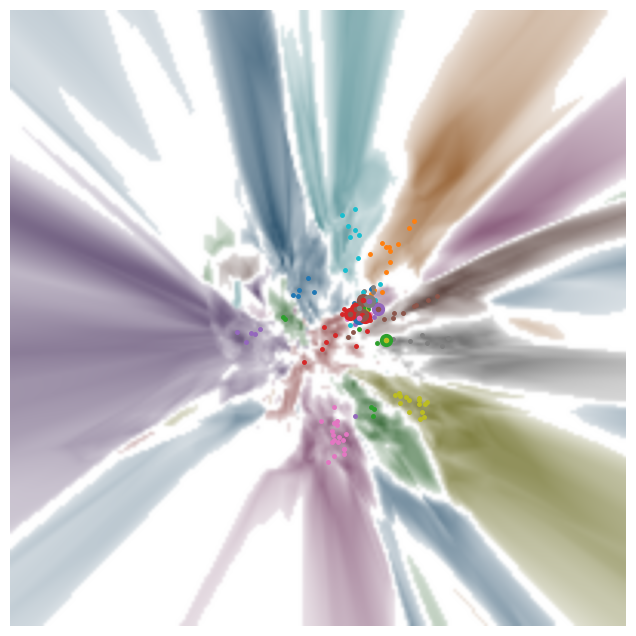

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, final_S,I, np.dot(tar_provider.train_representation(200),final_R), projector, 200,[need_train],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 3945.72it/s]


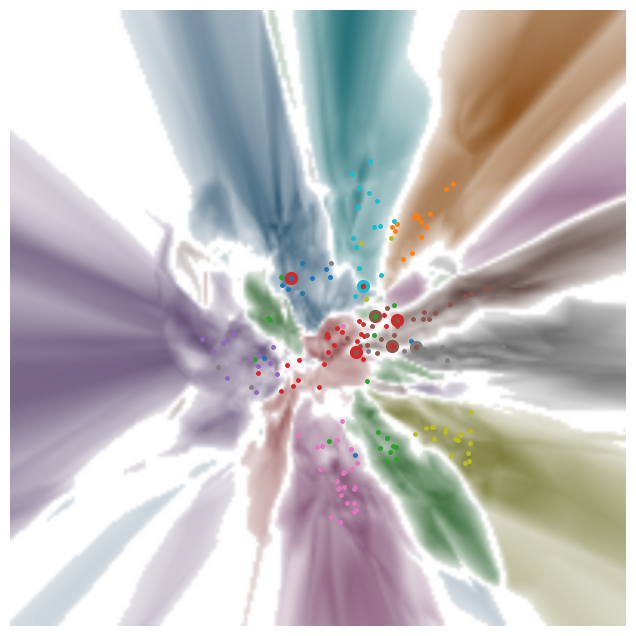

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(200),I), projector, 200,[need_train],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
S= align_embeddings(ref_train_data[pred_diff_list],tar_train_data[pred_diff_list])

iteration: 0 losss: tensor(55202628., grad_fn=<DivBackward0>)
